In [1]:
from astropy.table import Table
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
glob('catalogs/*')

['catalogs/hlsp_candels_hst_wfc3_egs-tot-multiband_f160w_v1_cat.fits',
 'catalogs/hlsp_candels_hst_wfc3_egs_v1_mass_cat.fits',
 'catalogs/hlsp_candels_hst_wfc3_egs_v1_photoz_cat.fits',
 'catalogs/hlsp_candels_hst_wfc3_egs_v1_physpar_cat.fits']

In [3]:
Mass = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs_v1_mass_cat.fits')[1], format = 'fits').to_pandas()
Photz = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs_v1_photoz_cat.fits')[1], format = 'fits').to_pandas()
Physpar = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs_v1_physpar_cat.fits')[1], format = 'fits').to_pandas()
Cat = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs-tot-multiband_f160w_v1_cat.fits')[1], format = 'fits').to_pandas()

In [4]:
np.array(Photz.columns)

array(['ID', 'Photo_z_Median', 'Photo_z_Salvato', 'Photo_z_Mobasher',
       'Photo_z_Finkelstein', 'Photo_z_Barro', 'Photo_z_Wiklind',
       'Photo_z_Wuyts', 'D95', 'Spec_z', 'Photo_z_lower_68',
       'Photo_z_upper_68', 'Photo_z_lower_95', 'Photo_z_upper_95'], dtype=object)

In [5]:
uvjDF = pd.DataFrame({'id' : Cat['ID'] ,'ra' : Cat['RA'],'dec' : Cat['DEC'], 'photz' : Photz['Photo_z_Median'],
                      'u' : Physpar['UMag_6a_deltau'] ,'v' : Physpar['VMag_6a_deltau']  ,'j' : Physpar['JMag_6a_deltau'],
                      'u-v' : Physpar['UMag_6a_deltau'] - Physpar['VMag_6a_deltau'] ,'v-j': Physpar['VMag_6a_deltau'] - Physpar['JMag_6a_deltau'],
                      'class_star' : Cat['CLASS_STAR'],'ssfr' : Physpar['SFR_6a_deltau'] / 10**Mass['M_med'],
                      'lmass' : Mass['M_med'] ,'H' : Cat['WFC3_F160W_FLUX']})

In [6]:
uvjDF = uvjDF[uvjDF.class_star < 0.8]
uvjDF = uvjDF[uvjDF.lmass > 10.0 ]
uvjDF = uvjDF[uvjDF.photz > 1.5 ]

In [7]:
qsflag = np.repeat('s',repeats=len(uvjDF.index))

for i in range(len(qsflag)):
    if uvjDF['u-v'].values[i]>=0.88*uvjDF['v-j'].values[i]+0.59 and uvjDF['u-v'].values[i]>1.382 and uvjDF['v-j'].values[i]<1.65:
        qsflag[i] = 'q'
        
uvjDF['SF'] = qsflag
qDF = uvjDF[uvjDF.SF == 'q']
sDF = uvjDF[uvjDF.SF == 's']

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


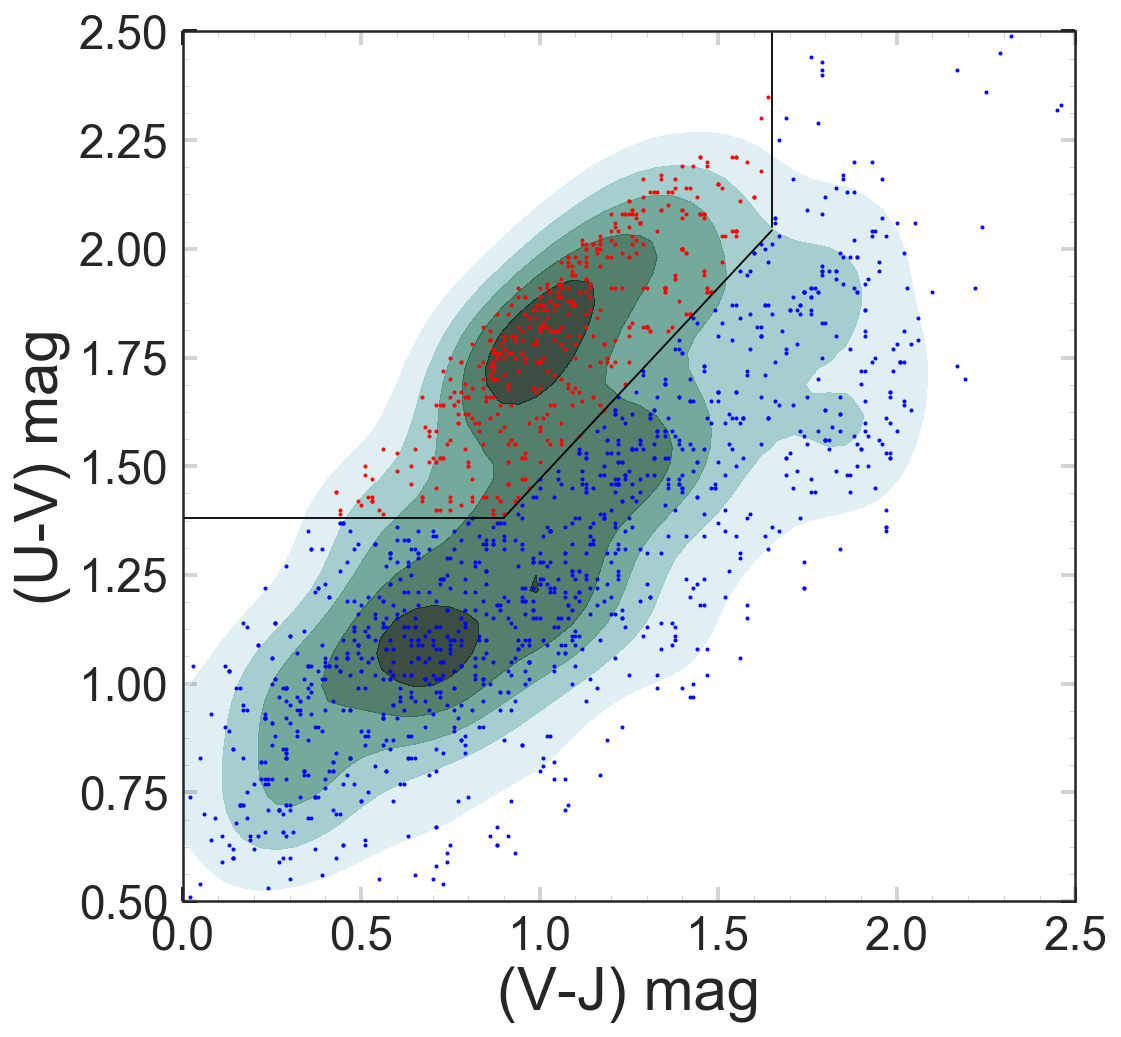

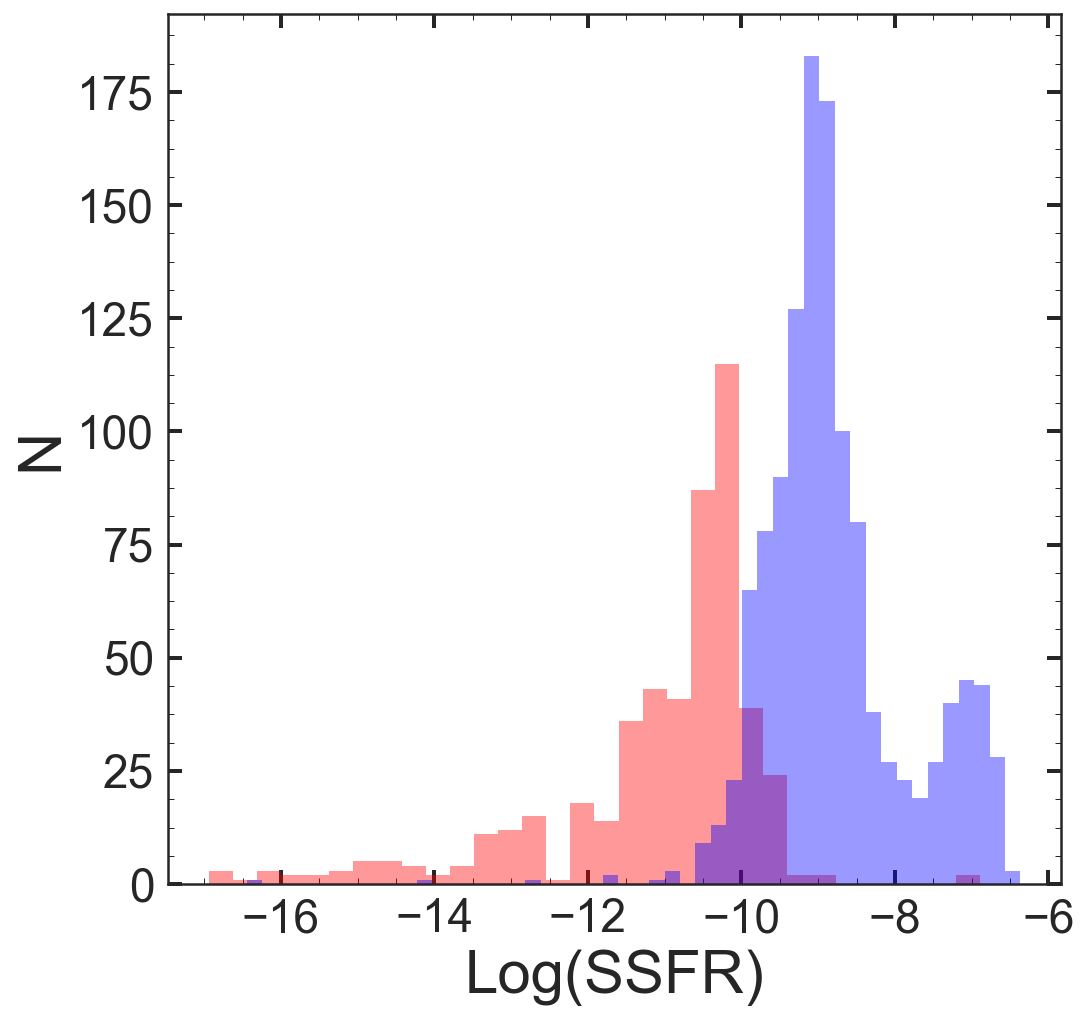

In [90]:
plt.figure(figsize=[8,8])
sea.kdeplot(uvjDF['v-j'],uvjDF['u-v'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.plot(qDF['v-j'],qDF['u-v'],'ro',ms=2)
plt.plot(sDF['v-j'],sDF['u-v'],'bo',ms=2)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.savefig('uvj.png',bbox_inches='tight') 

plt.figure(figsize=[8,8])
sea.distplot(np.log10(qDF['ssfr'].values)[np.log10(qDF['ssfr'].values) > -100],color='r',norm_hist=False,kde=False)
sea.distplot(np.log10(sDF['ssfr'].values)[np.log10(sDF['ssfr'].values) > -100],color='b',norm_hist=False,kde=False)
plt.xlabel('Log(SSFR)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.savefig('ssfr.png',bbox_inches='tight') 

plt.figure(figsize=[8,8])
sea.distplot(np.log10(qDF['lmass'].values)[np.log10(qDF['lmass'].values) > -100],color='r',norm_hist=False,kde=False)
sea.distplot(np.log10(sDF['lmass'].values)[np.log10(sDF['lmass'].values) > -100],color='b',norm_hist=False,kde=False)
plt.xlabel('Log(SSFR)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.savefig('ssfr.png',bbox_inches='tight') 

plt.figure(figsize=[8,8])
sea.distplot(np.log10(qDF['ssfr'].values)[np.log10(qDF['ssfr'].values) > -100],color='r',norm_hist=False,kde=False)
sea.distplot(np.log10(sDF['ssfr'].values)[np.log10(sDF['ssfr'].values) > -100],color='b',norm_hist=False,kde=False)
plt.xlabel('Log(SSFR)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.savefig('ssfr.png',bbox_inches='tight') 

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


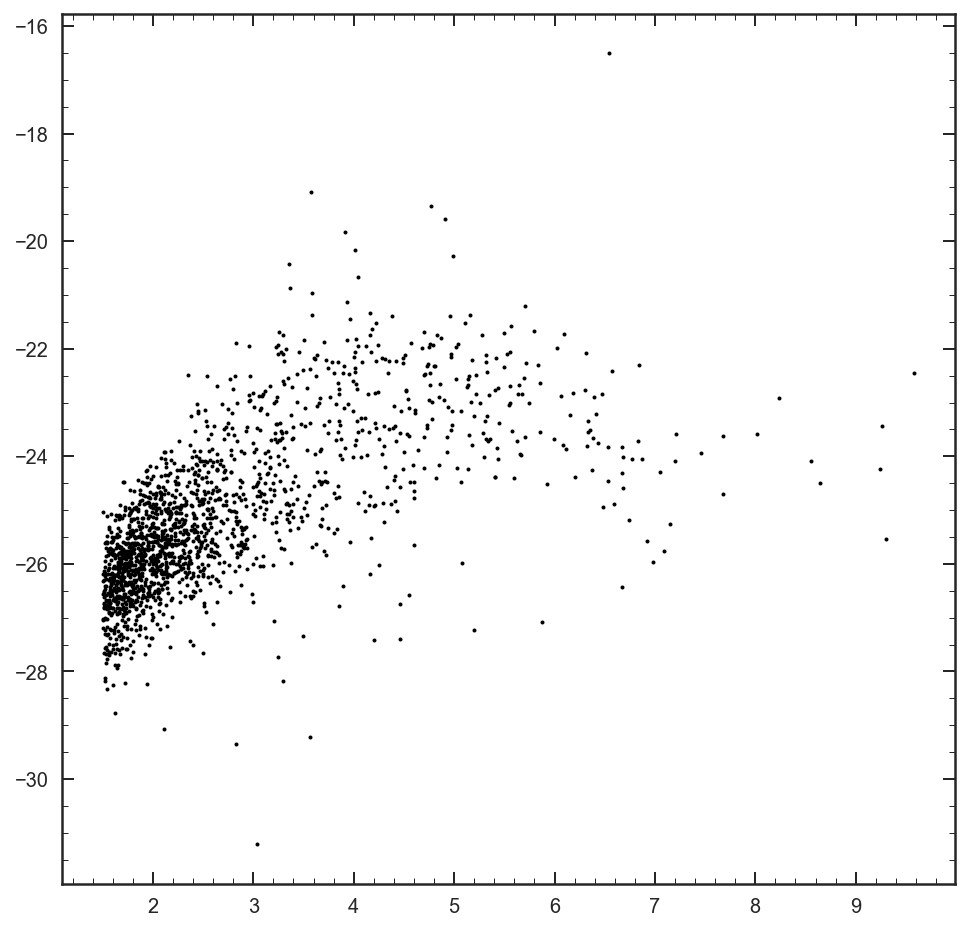

In [34]:
plt.figure(figsize=[8,8])
plt.plot(uvjDF['photz'], -2.5*np.log10(uvjDF['H'])-25 ,'ko',ms=2)


In [10]:
def ra_dec_convert(ra,dec):
    # ra - [hours,minutes,seconds]
    # dec - [degrees,arcminutes,arcseconds]
    
    RA = 15*(ra[0]+ ra[1]/60. + ra[2]/60./60.) 
    DEC = dec[0] + dec[1]/60. + dec[2]/60./60. 
    
    return RA,DEC

In [11]:
hsm_ra_dec = np.array([[[14,20,26.54], [52,57,15.7]],
              [[14,20,09.36], [52,57,34.0]],
              [[14,20,04.32], [52,53,30.4]],
              [[14,19,47.04], [52,53,45.4]]])
              
P = []
for i in range(len(hsm_ra_dec)):
    ra,dec = ra_dec_convert(hsm_ra_dec[i][0],hsm_ra_dec[i][1])
    P.append([ra,dec])

In [13]:
C =np.pi / 180.
alpha = 49.
theta = 90. - alpha
d=129./60/60
c=43./60/60

bR = - (d + c/2) * np.array([np.cos(theta*C),np.sin(theta*C)])
X = (d/2) * np.array([-np.cos(alpha*C),np.sin(alpha*C)])
tR = (c/2) * np.array([np.cos(theta*C),np.sin(theta*C)])

sPb = P + bR + X
tPb = P + tR + X

In [19]:
box = [[[14,19,58.51], [52,50,53.0]], [[14,20,08.04], [52,52,31.0]], [[14,19,57.06], [52,53,54.6]], [[14,19,47.84], [52,52,17.9]],
[[14,19,41.22], [52,51,08.2]], [[14,19,50.74], [52,52,47.0]], [[14,19,39.68], [52,54,10.5]], [[14,19,30.46], [52,52,34.4]],
[[14,20,11.46], [52,53,03.5]], [[14,20,20.86], [52,54,42.7]], [[14,20,10.03], [52,56,05.0]], [[14,20,00.71], [52,54,29.1]],
[[14,19,54.16], [52,53,18.8]], [[14,20,03.47], [52,54,58.1]], [[14,19,52.63], [52,56,21.7]], [[14,19,43.32], [52,54,45.6]],
[[14,20,20.63], [52,54,38.0]], [[14,20,30.26], [52,56,16.6]], [[14,20,19.28], [52,57,40.9]], [[14,20,10.10], [52,56,05.0]],
[[14,20,03.32], [52,54,56.1]], [[14,20,12.86], [52,56,34.8]], [[14,20,01.95], [52,57,58.3]], [[14,19,52.63], [52,56,21.7]],
[[14,20,33.62], [52,56,49.6]], [[14,20,43.04], [52,58,27.5]], [[14,20,32.06], [52,59,51.2]], [[14,20,22.87], [52,58,16.1]],
[[14,20,16.30], [52,57,07.2]], [[14,20,25.78], [52,58,46.4]], [[14,20,14.79], [53,0,09.4]], [[14,20,05.60], [52,58,33.5]]]

In [ ]:
BOX = []
for i in range(len(box)):
    ra,dec = ra_dec_convert(box[i][0],box[i][1])
    BOX.append([ra,dec])

In [91]:
q_inout = np.repeat('out',len(qDF.index))
s_inout = np.repeat('out',len(sDF.index))
for i in range(8):
    param1 = np.polyfit([BOX[0 + i*4][0],BOX[1 + i*4][0]],[BOX[0 + i*4][1],BOX[1 + i*4][1]],1)
    param2 = np.polyfit([BOX[1 + i*4][0],BOX[2 + i*4][0]],[BOX[1 + i*4][1],BOX[2 + i*4][1]],1)
    param3 = np.polyfit([BOX[2 + i*4][0],BOX[3 + i*4][0]],[BOX[2 + i*4][1],BOX[3 + i*4][1]],1)
    param4 = np.polyfit([BOX[3 + i*4][0],BOX[0 + i*4][0]],[BOX[3 + i*4][1],BOX[0 + i*4][1]],1)

    for ii in range(len(qDF.index)):
        if qDF['dec'].values[ii] > param1[0]*qDF['ra'].values[ii] + param1[1] \
        and qDF['dec'].values[ii] < param2[0]*qDF['ra'].values[ii] + param2[1] \
        and qDF['dec'].values[ii] < param3[0]*qDF['ra'].values[ii] + param3[1] \
        and qDF['dec'].values[ii] > param4[0]*qDF['ra'].values[ii] + param4[1]:
            q_inout[ii] = 'in'
            
    for ii in range(len(sDF.index)):
        if sDF['dec'].values[ii] > param1[0]*sDF['ra'].values[ii] + param1[1] \
        and sDF['dec'].values[ii] < param2[0]*sDF['ra'].values[ii] + param2[1] \
        and sDF['dec'].values[ii] < param3[0]*sDF['ra'].values[ii] + param3[1] \
        and sDF['dec'].values[ii] > param4[0]*sDF['ra'].values[ii] + param4[1]:
            s_inout[ii] = 'in'

In [92]:
qDF['inout'] = q_inout
sDF['inout'] = s_inout


/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [93]:
sampleDF = qDF[qDF.inout == 'in']
sf_sampleDF = sDF[sDF.inout == 'in']

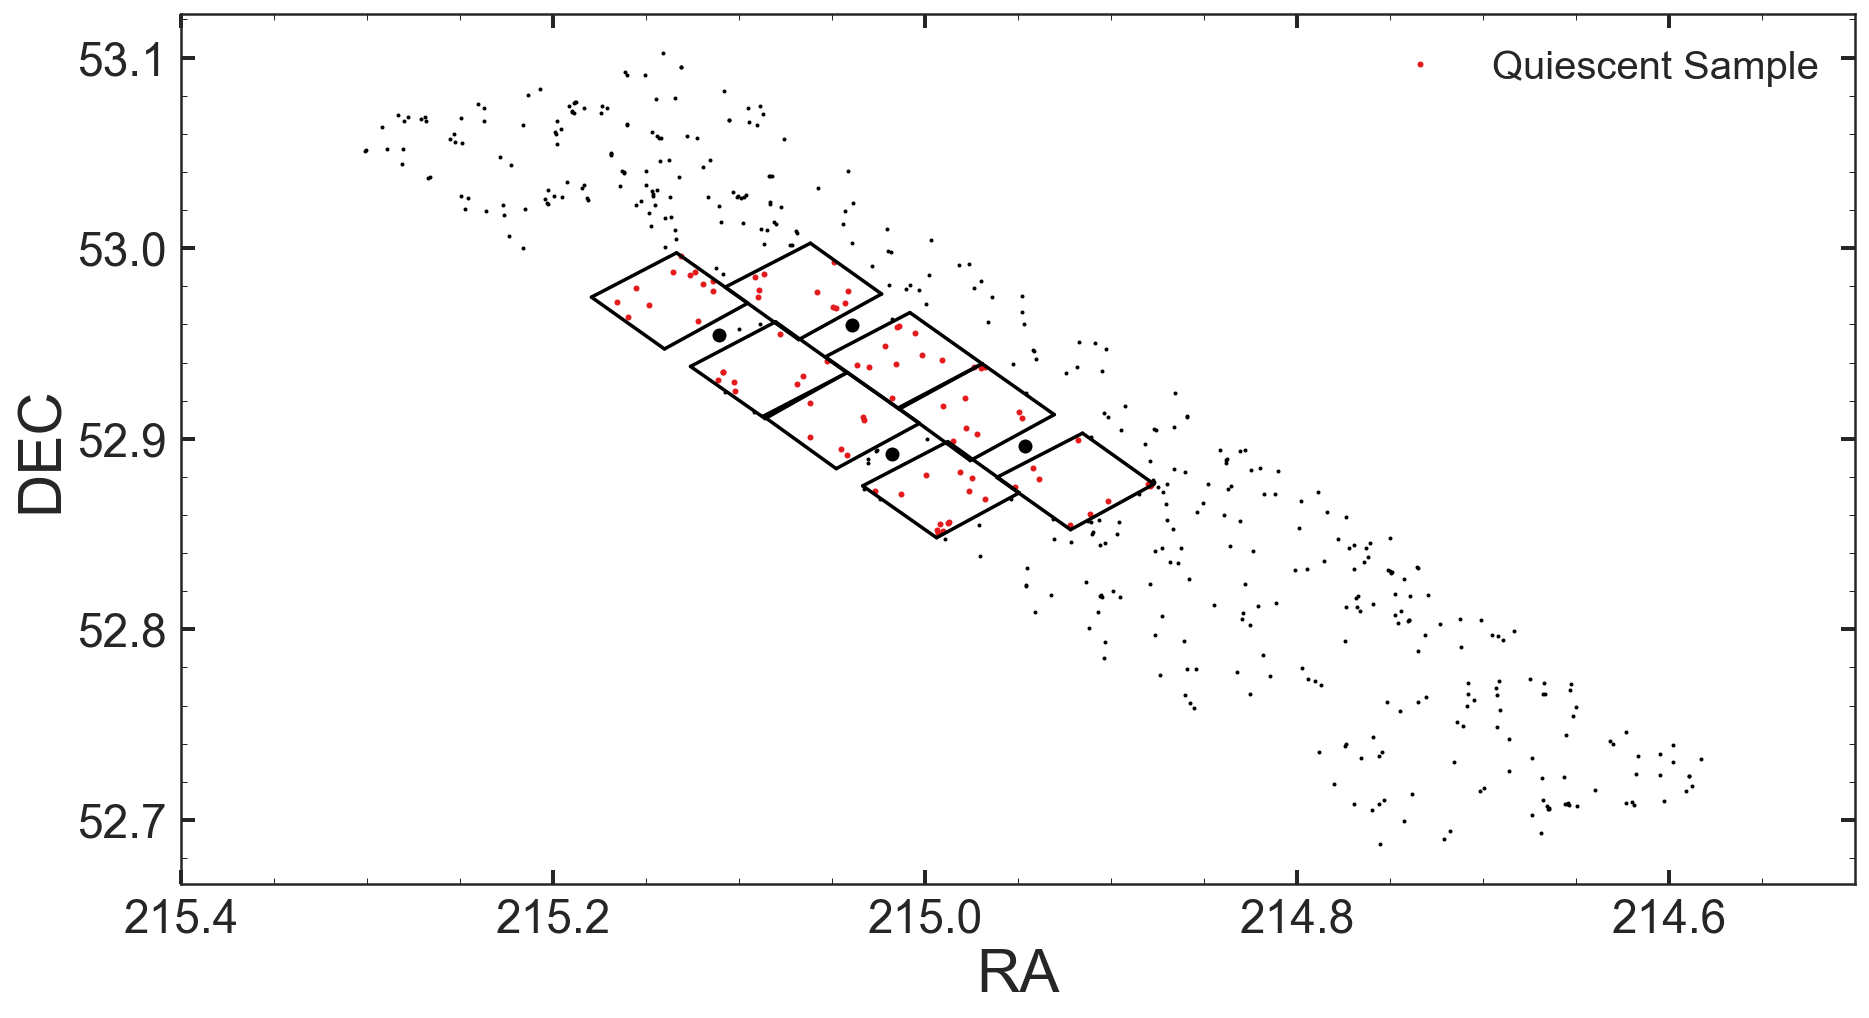

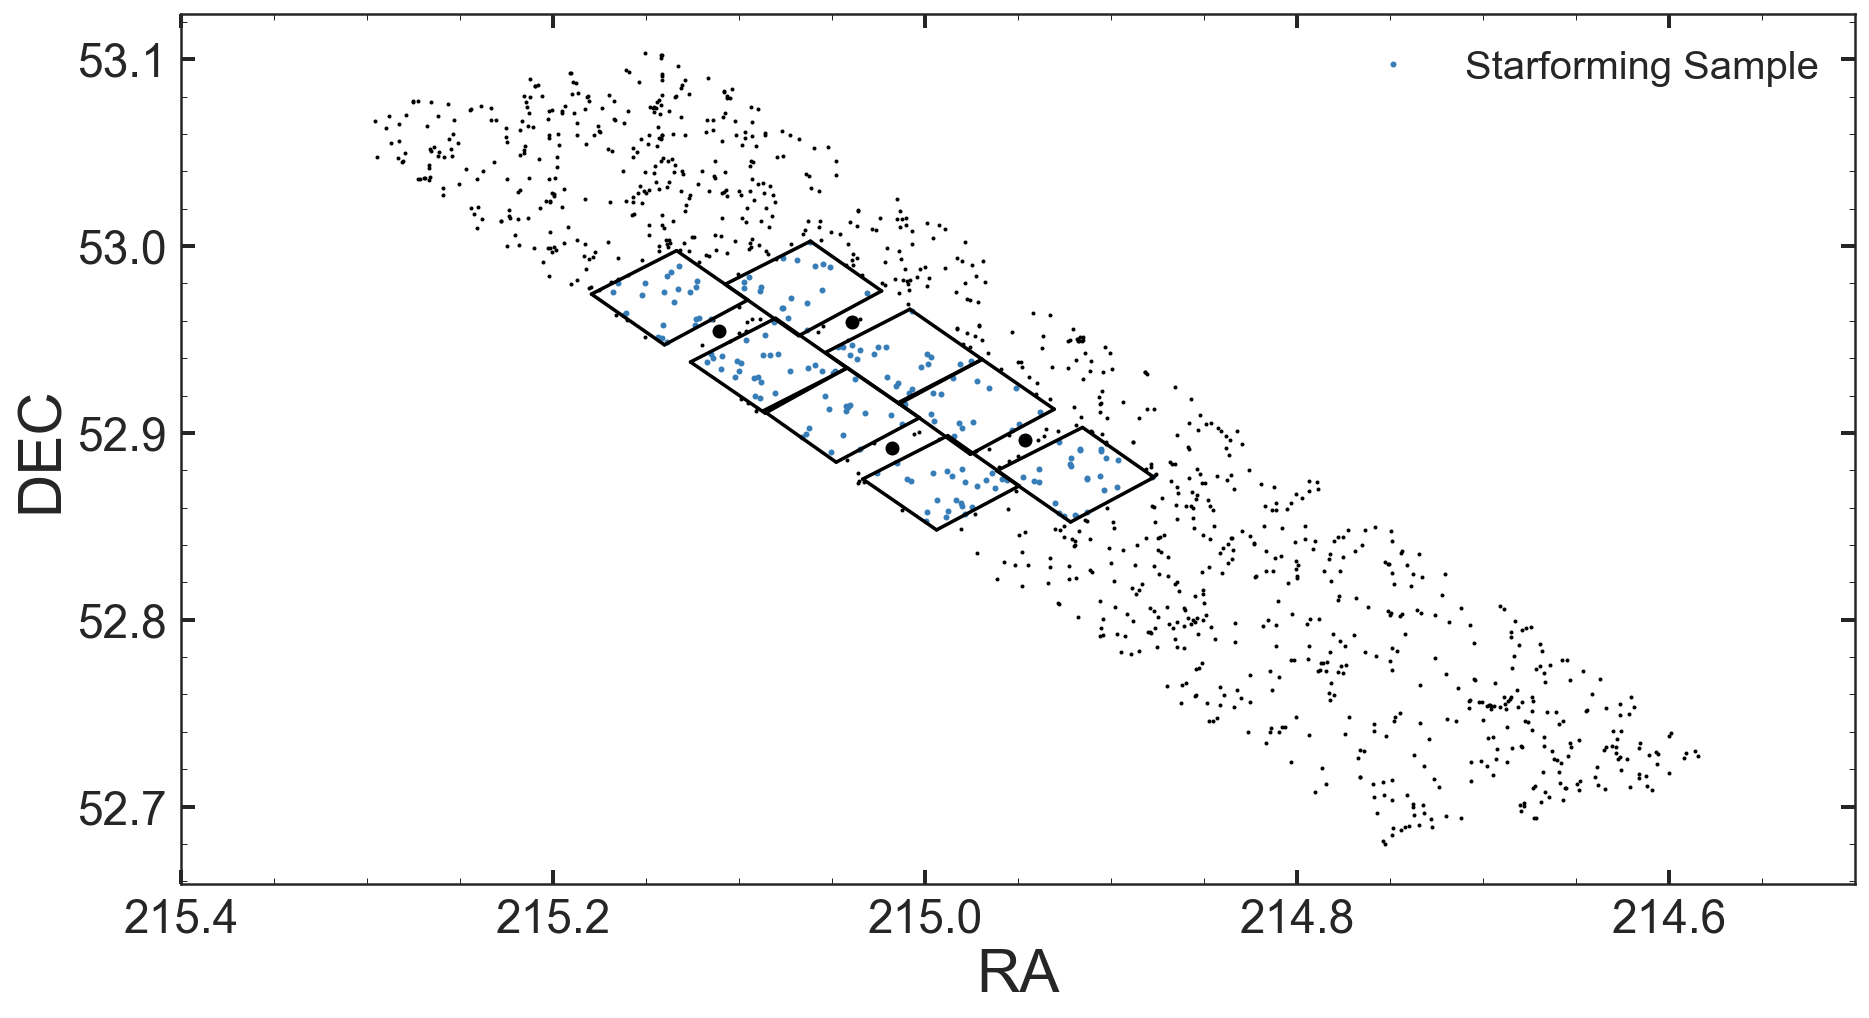

In [101]:
fig2 = plt.figure(figsize=[15,8])
ax2 = fig2.add_subplot(111)#,aspect='equal')
plt.plot(qDF['ra'].values, qDF['dec'].values ,'ko',ms=2)
plt.plot(sampleDF['ra'], sampleDF['dec'] ,'o',color='#e41a1c',ms=3,label='Quiescent Sample')

for i in range(len(P)):
    plt.plot(P[i][0],P[i][1],'ko')

u=1
for i in range(len(BOX)):
    if u == 4:
        plt.plot([BOX[i][0],BOX[i-3][0]],[BOX[i][1],BOX[i-3][1]],'k')
        u=1
    else:
        plt.plot([BOX[i][0],BOX[i+1][0]],[BOX[i][1],BOX[i+1][1]],'k')
        u+=1
   
plt.xlabel('RA',fontsize=30)
plt.ylabel('DEC',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.legend(fontsize=20)
plt.xlim(215.4,214.5)
plt.savefig('field.png',bbox_inches='tight') 

#####################################################

fig2 = plt.figure(figsize=[15,8])
ax2 = fig2.add_subplot(111)#,aspect='equal')
plt.plot(sDF['ra'].values, sDF['dec'].values ,'ko',ms=2)
plt.plot(sf_sampleDF['ra'], sf_sampleDF['dec'] ,'o',color='#377eb8',ms=3,label='Starforming Sample')

for i in range(len(P)):
    plt.plot(P[i][0],P[i][1],'ko')

u=1
for i in range(len(BOX)):
    if u == 4:
        plt.plot([BOX[i][0],BOX[i-3][0]],[BOX[i][1],BOX[i-3][1]],'k')
        u=1
    else:
        plt.plot([BOX[i][0],BOX[i+1][0]],[BOX[i][1],BOX[i+1][1]],'k')
        u+=1
  
plt.xlabel('RA',fontsize=30)
plt.ylabel('DEC',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.xlim(215.4,214.5)
plt.legend(fontsize=20)
plt.savefig('sf_field.png',bbox_inches='tight') 

(array([ 33.,  24.,  11.,   2.,   5.,   0.,   3.,   0.,   1.,   1.]),
 array([ 1.502 ,  1.9163,  2.3306,  2.7449,  3.1592,  3.5735,  3.9878,
         4.4021,  4.8164,  5.2307,  5.645 ]),
 <a list of 10 Patch objects>)

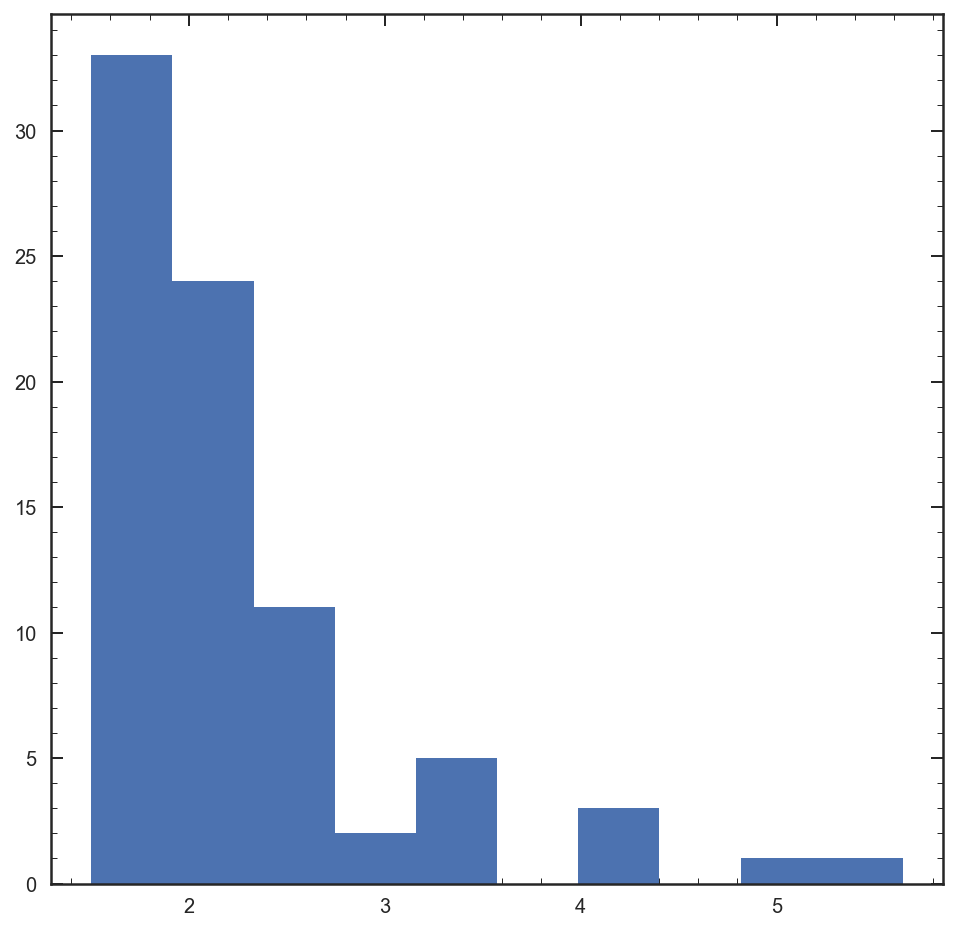

In [56]:
plt.figure(figsize=[8,8])
plt.hist(sampleDF['photz'])

In [59]:
wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.019_a1.0_dt8.0_spec.npy')

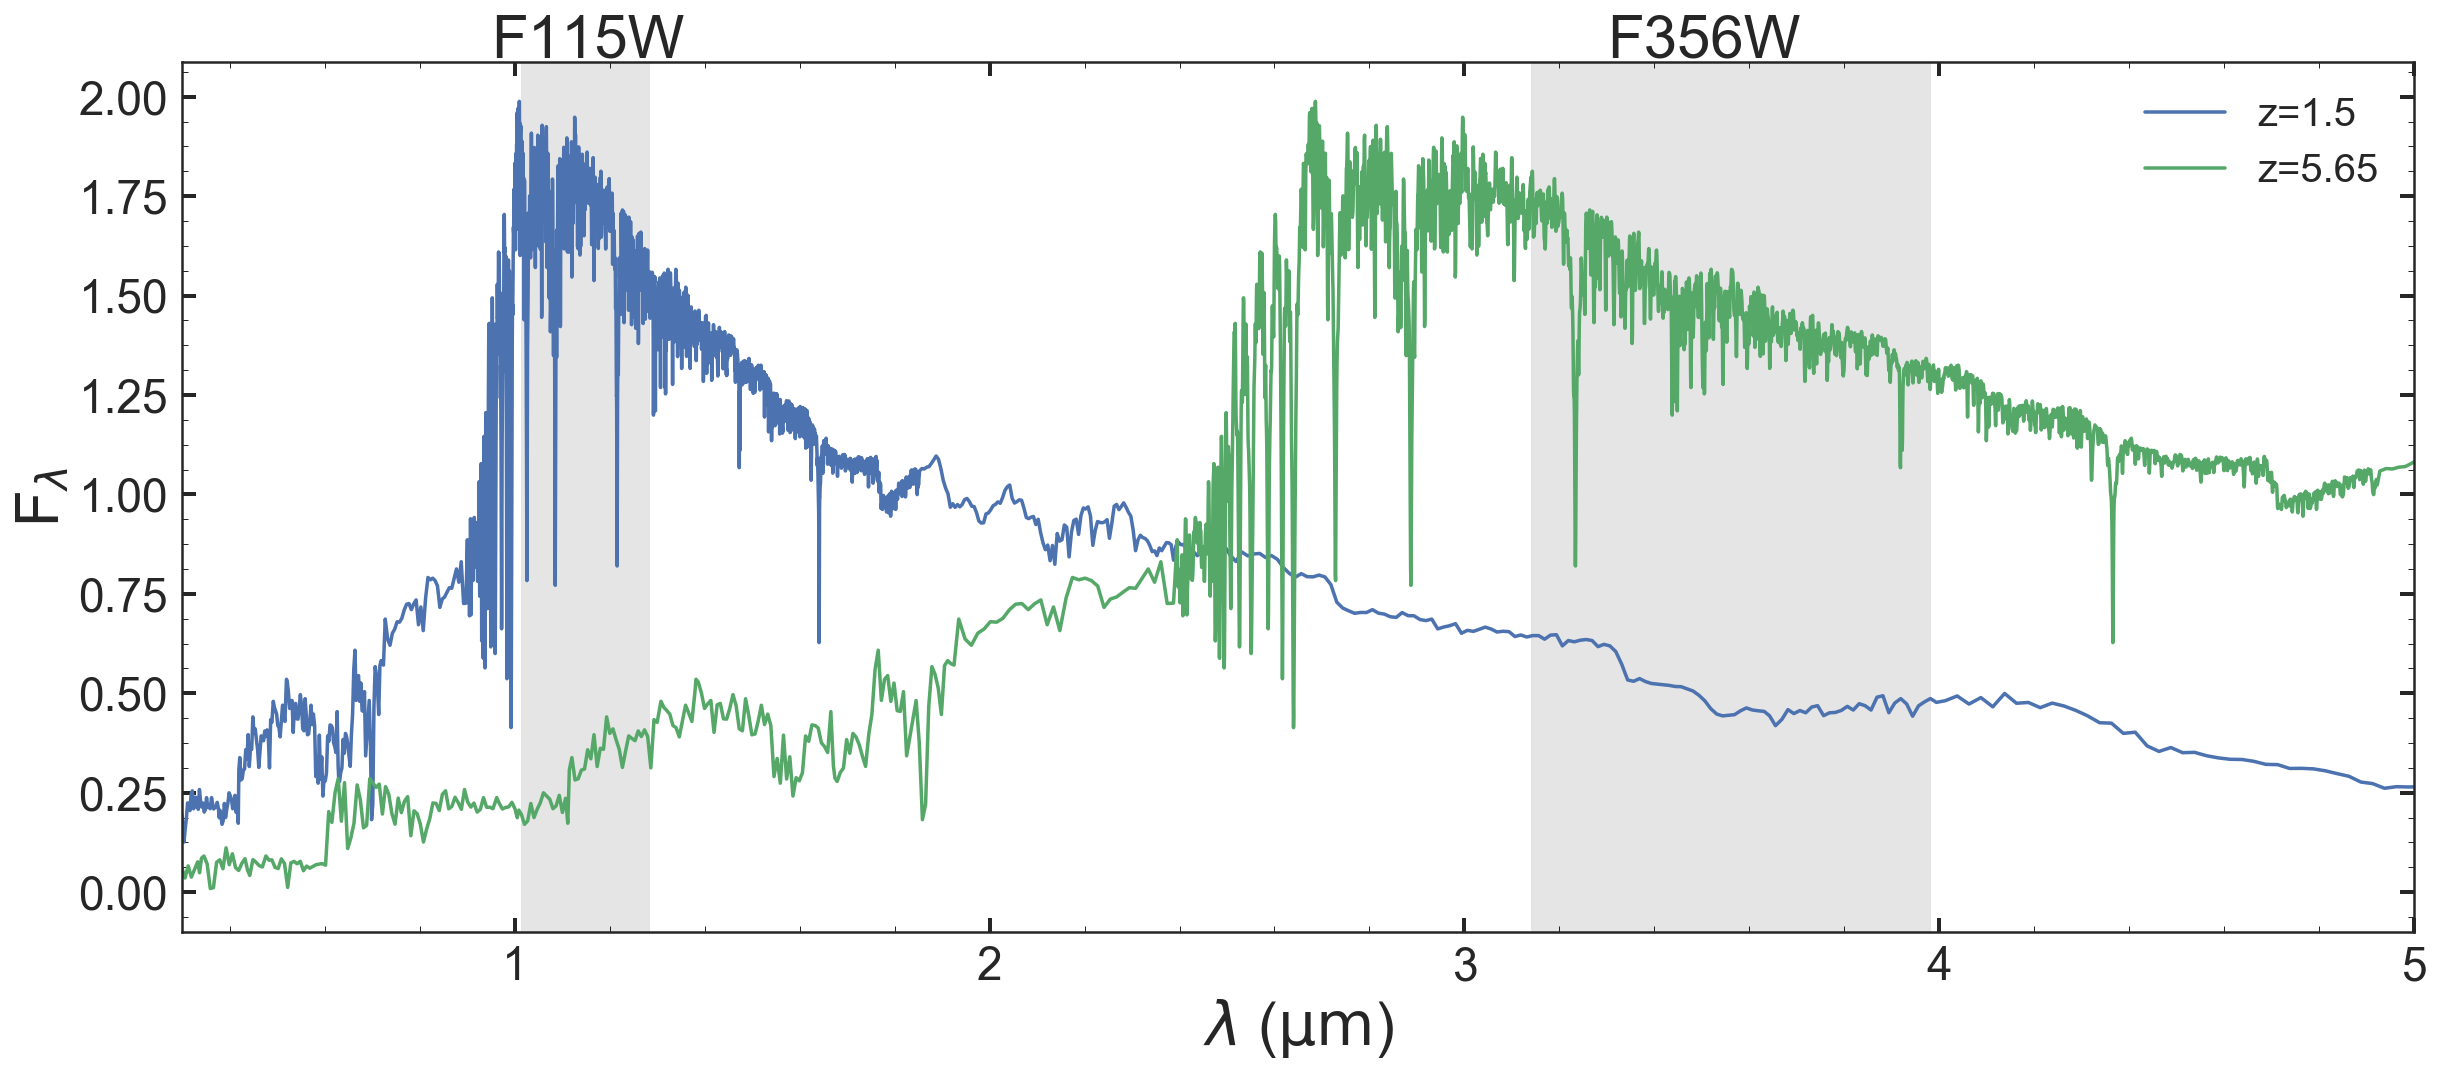

In [132]:
plt.figure(figsize=[20,8])
plt.plot(wv*(1+1.5)*1E-4,fl*1E4,label = 'z=1.5')
plt.plot(wv*(1+5.65)*1E-4,fl*1E4,label = 'z=5.65')
plt.axvspan(1.013, 1.282, color='k', alpha=.1)
plt.axvspan(3.14, 3.98, color='k', alpha=.1)
plt.xlim(.3,5)
plt.xlabel('$\lambda$ ($\\rm \mu m$)',fontsize=30)
plt.ylabel('F$_\lambda$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.legend(fontsize=20)
plt.text(.95,2.1,'F115W',fontsize=30)
plt.text(3.3,2.1,'F356W',fontsize=30)

plt.savefig('spec.png',bbox_inches='tight') 

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


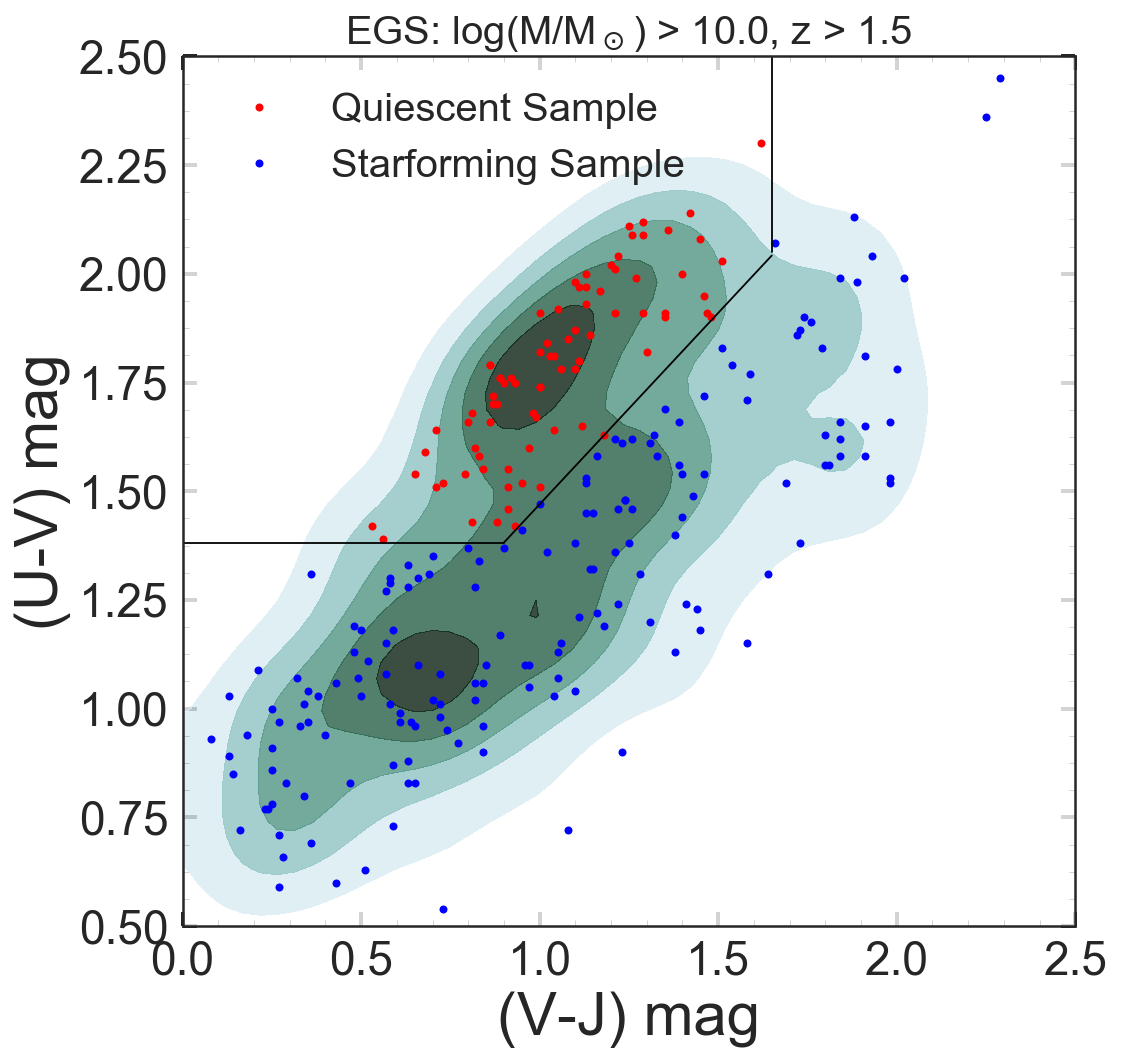

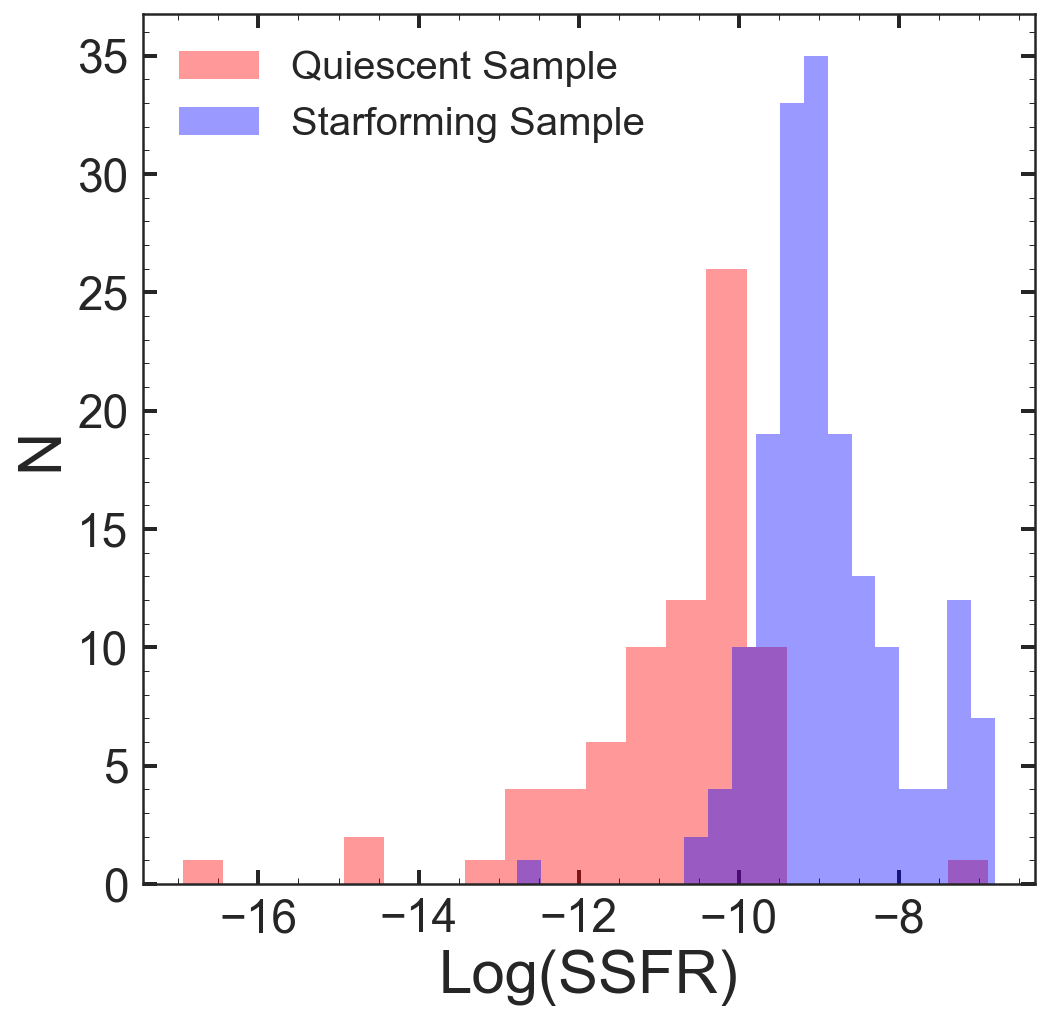

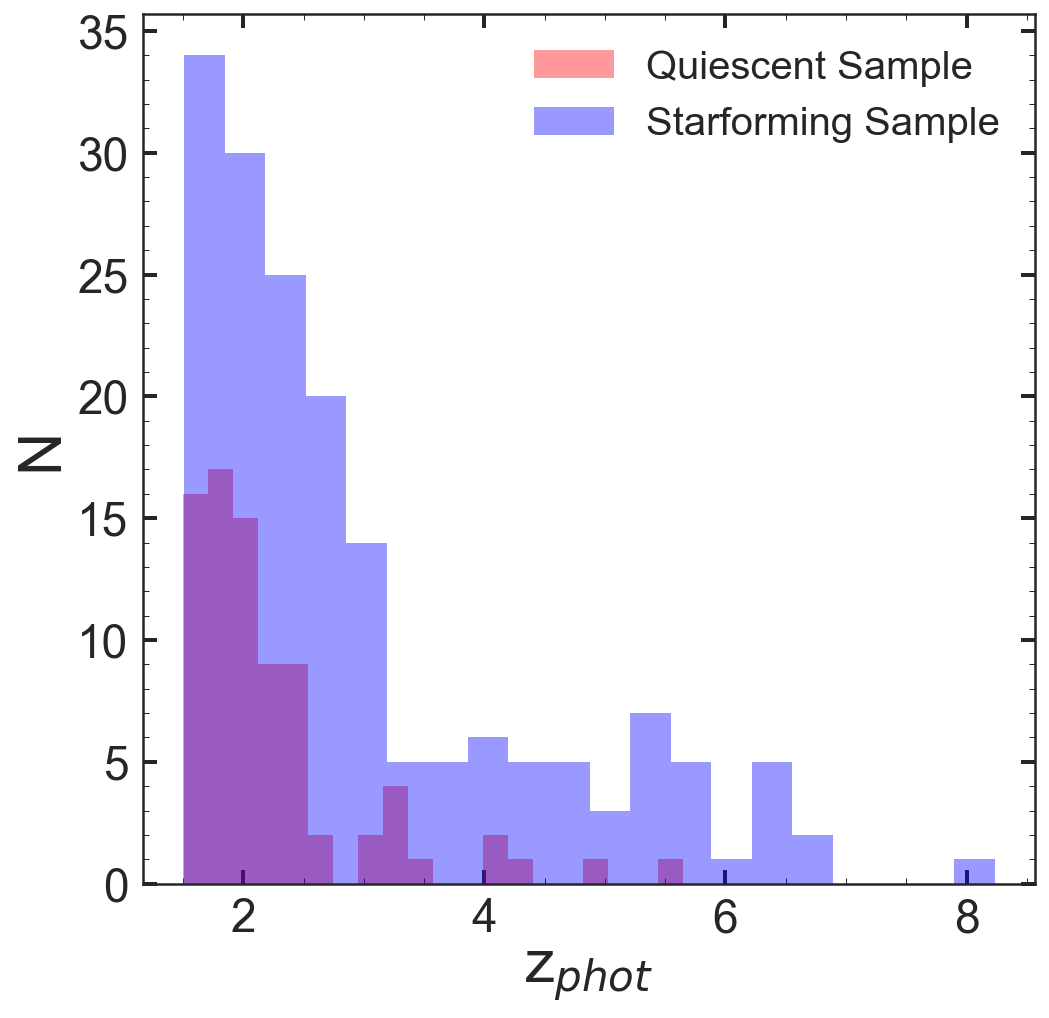

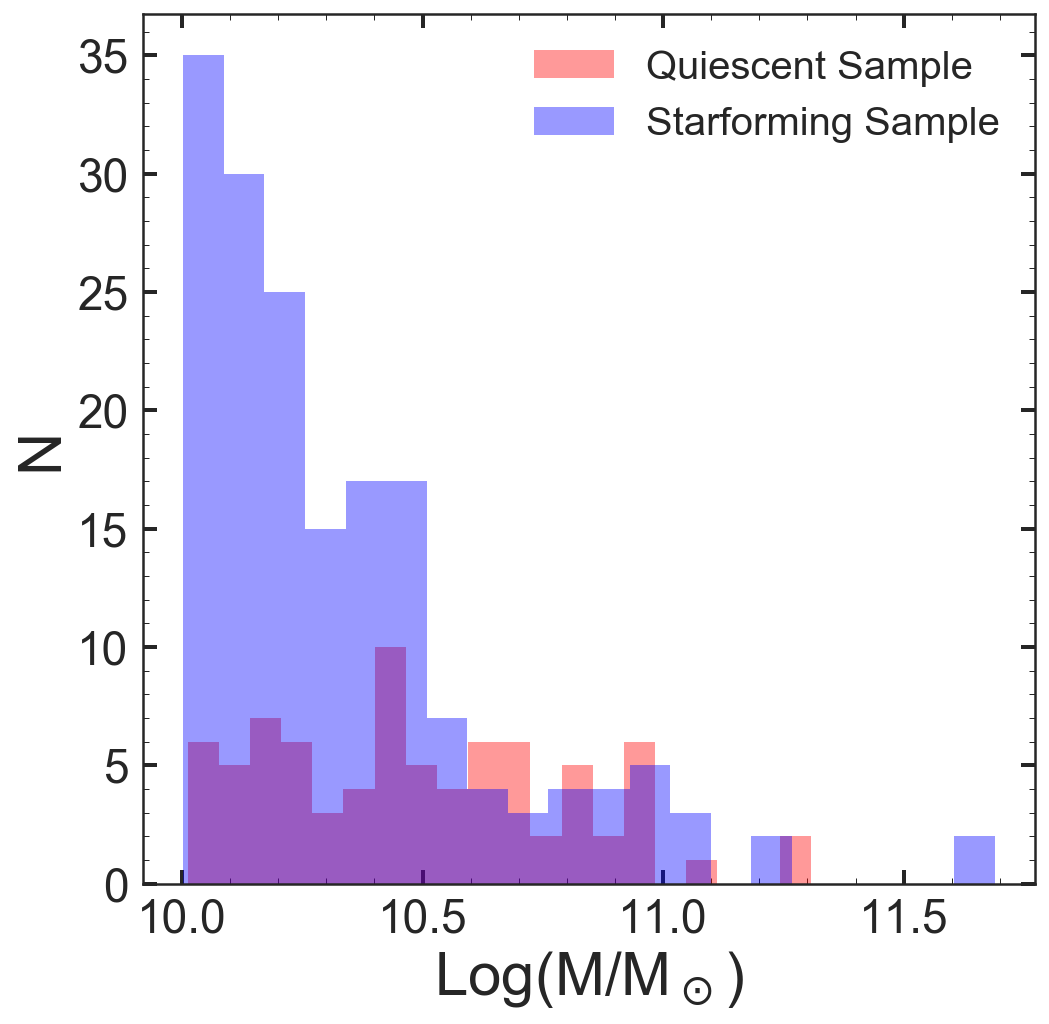

In [117]:
plt.figure(figsize=[8,8])
sea.kdeplot(uvjDF['v-j'],uvjDF['u-v'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1,
            label='EGS: log(M/M$_\odot$) > 10.0, z > 1.5')
plt.plot(sampleDF['v-j'],sampleDF['u-v'],'ro',ms=4,label='Quiescent Sample')
plt.plot(sf_sampleDF['v-j'],sf_sampleDF['u-v'],'bo',ms=4,label='Starforming Sample')
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.legend(fontsize=20)
plt.title('EGS: log(M/M$_\odot$) > 10.0, z > 1.5',fontsize=20)
plt.savefig('uvj.png',bbox_inches='tight') 

################################

plt.figure(figsize=[8,8])
sea.distplot(np.log10(sampleDF['ssfr'].values)[np.log10(sampleDF['ssfr'].values) > -100],color='r',norm_hist=False,
             bins=20,kde=False,label='Quiescent Sample')
sea.distplot(np.log10(sf_sampleDF['ssfr'].values)[np.log10(sf_sampleDF['ssfr'].values) > -100],color='b',norm_hist=False,
             bins=20,kde=False,label='Starforming Sample')
plt.xlabel('Log(SSFR)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.legend(fontsize=20)
plt.savefig('ssfr.png',bbox_inches='tight') 

################################

plt.figure(figsize=[8,8])
sea.distplot(sampleDF['photz'],color='r',norm_hist=False,bins=20,kde=False,label='Quiescent Sample')
sea.distplot(sf_sampleDF['photz'],color='b',norm_hist=False,bins=20,kde=False,label='Starforming Sample')
plt.xlabel('z$_{phot}$',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.legend(fontsize=20)
plt.savefig('photz.png',bbox_inches='tight') 

################################

plt.figure(figsize=[8,8])
sea.distplot(sampleDF['lmass'],color='r',norm_hist=False,bins=20,kde=False,label='Quiescent Sample')
sea.distplot(sf_sampleDF['lmass'],color='b',norm_hist=False,bins=20,kde=False,label='Starforming Sample')
plt.xlabel('Log(M/M$_\odot$)',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.legend(fontsize=20)
plt.savefig('lmass.png',bbox_inches='tight') 

In [134]:
print len(sampleDF.index)
print len(sf_sampleDF.index)

80
173
